Let’s begin the analysis by importing libraries and the data set into Python.

In [1]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns

#reading Dataset
retail = pd.read_csv("Online+Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [2]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# Sanity Check
# retail.shape
# retail.describe()
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
#Na Handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Let's start with some preliminary data cleaning. Now, as you can notice, the data set is at the granularity of order level. So, it doesn’t make much sense to do missing value imputation because it would be very difficult to predict the individual missing details of individual orders. Hence, you have to remove the entries with the missing values.

In [7]:
#dropping the na cells
order_wise = retail.dropna()

In [11]:
type(order_wise)

pandas.core.frame.DataFrame

In [12]:
#Sanity check
# order_wise.shape()
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

But, if you remember, our main objective is to cluster the customers of the online store. So, you need to transform this order-wise data into customer-wise data by finding key attributes that best characterises a customer. This is achieved through RFM analysis.

 

### RFM analysis

In RFM analysis, you look at the recency, frequency and the monetary scores of all the customers for segmentation.

Recency: It measures how recently you visited the store or made a purchase

Frequency: It measures the frequency of the transactions the customers made

Monetary: It measures how much the customer spent on purchases he/she made

 

So, your target is to compute the RFM numbers for each customer, which effectively means that the granularity level of your data set will change from Invoice number to the CustomerID. Thus, you will have one unique row corresponding to each customer.
 

Let’s start with creating customer-wise data. We begin with the computation of M of the RFM, that is the total monetary value of the purchases made by each customer.

 

Create a vector named Amount, which creates the total monetary value of each order, and append the column to your data set.

In [15]:
#RFM implementation
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])

#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

In [16]:
order_wise.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [27]:
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


In [32]:
order_wise.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Now, sort the data set in order of CustomerID. Next, create a new vector — monetary — which gives the aggregated purchase amount for each customer.

In [33]:
#Monetary Function
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()

In [34]:
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


This data frame monetary is the M of the RFM framework.

 

Next, let’s compute the frequency of purchase for each customer, i.e. the F of the RFM framework. For this, you will count the number of unique Invoice Numbers for each Customer ID.  This is the “Frequency” corresponding to each customer.

In [28]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]

In [29]:
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Finally, merge this data frame with the “Frequency” of each customer into your earlier data set containing the “Monetary” value.  

In [25]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")

In [31]:
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17



Thus, the data frame master contains both the monetary and the frequency attributes corresponding to each customer IDs. Now, you have to turn your attention towards the computation of the recency, i.e. for how long a customer has not visited the online store.

 

Begin by extracting the Customer ID and Invoice Date from the data. Now, find the latest “Invoice Date” which forms the reference point for the calculation of the “Recency” of each customer. For each order corresponding to each customer, you find the difference from the latest “Invoice Date” and then find the minimum “Recency” value for each customer.

In [24]:
#Generating recency function
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate

#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]

C:\Users\anish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Now, the data frame recency contains the recency for each customer. Let’s merge it to the RFM data set and change the format to the required form.

In [35]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")

In [36]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


Thus, you have obtained the RFM data corresponding to each customer. These 3 attributes will form the basis, depending on which the customers will be segregated into different clusters.

 

However, your data preparation is still not complete. You have already seen previously how the clustering process can be impacted due to the presence of outliers. So, let’s treat the data set for outliers. One way to do it is by eliminating all the data points which fall outside the 1.5 times the IQR of the 1st and the 3rd quartile.

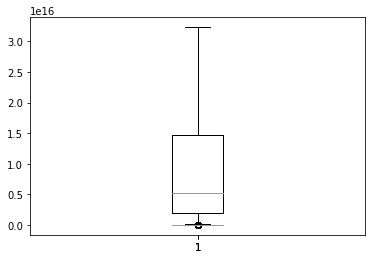

In [37]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [39]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00


Now, you will actually create clusters on the cleaned data. Let's see how this is done.

In [38]:
classmodel_clus = KMeans(n_clusters=3, init='random', n_init=10, max_iter=50).fit(RFM_norm1)

NameError: name 'RFM_norm1' is not defined

Here, let's try to understand the different parameters from Scikit Learn Documentation:

n_clusters: The number of clusters to form as well as the number of centroids to generate.

init: Method for initialization of the cluster centres

n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia (explained below).

max_iter: Maximum number of iterations of the k-means algorithm for a single run in case it doesn't converge on its own

Let's now try to understand the output of the KMeans() function.

cluster_centers: Coordinates of cluster centres

labels: Labels of each point i.e. the labels to which the points belong

inertia: Sum of squared distances of points to their closest cluster centre

Now the question arises, how do we really decide the number of cluster centres or in other words, the value of K in the K-Means algorithm?

As you saw, business constraints are one of the factors that help decide the value of K. However, there is a mathematical route as well to arrive at the optimal value of K. This is done through the elbow curve method.

 

You have seen earlier that KMeans() stores the sum of the squared distance of the points to their respective clusters centres as inertia. In other words, inertia represents, how tightly the different clusters are formed. As we increase the number of clusters, the inertia value is bound to decrease as the individual clusters become more compact. Thus, the plot of inertia against the number of clusters becomes a monotonically decreasing plot.

 

However, in this plot (Fig 1), you can notice a distinct elbow. Beyond the elbow point, the additional (marginal) decrease in inertia with each increase in the cluster number is not very prominent. Thus, the elbow in the curve gives an estimate of the optimal number K in K Means.

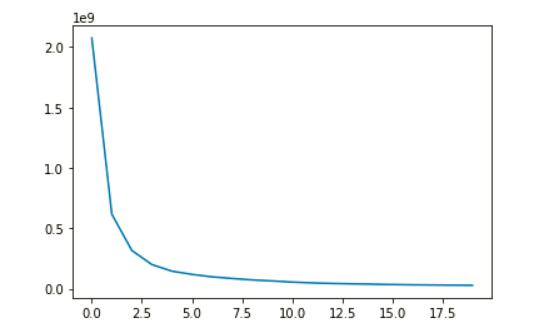

Now let's implement the elbow curve method to see what would be the optimal number of K in our case. We would use a loop to store the inertia value while changing the value of K from 1 to 21.

 

We will also be looking at Hopkins statistics in Python to check if our data has some meaningful clusters or not. Together with Hopkins and SSD, we will also test our clusters using Silhouette analysis.